# BERT Sentiment Classification

Bidirectional Encoder Representations from Transformers (BERT) for Natural Language Understanding

* Transfer learning
* Fine tuning

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
!pip install --quiet bert-for-tf2
!pip install --quiet sentencepiece

     |████████████████████████████████| 40kB 2.0MB/s 
     |████████████████████████████████| 1.0MB 2.9MB/s 


In [0]:
import tensorflow_hub as hub
import bert
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout, Input, Dropout, GlobalAveragePooling1D, Lambda, GlobalMaxPooling1D
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import random

# Training Data

Download labeled data from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences)

In [0]:
!unzip -q "sentiment labelled sentences.zip"

In [5]:
files = ['sentiment labelled sentences/yelp_labelled.txt', 'sentiment labelled sentences/amazon_cells_labelled.txt', 'sentiment labelled sentences/imdb_labelled.txt']

df_list = []
for file in files:
    df = pd.read_csv(file, names=['comment', 'sentiment'], sep='\t')
    df_list.append(df)

data = pd.concat(df_list)
data['length'] = data.comment.str.split(' ').str.len()

max_seq_length = 128

# Keep only short comments
shortComments = data[data.length < max_seq_length-5]
print('Number of rows: %d' % len(shortComments))

shortComments.head()

Number of rows: 2743


,comment,sentiment,length
0,Wow... Loved this place.,1,4
1,Crust is not good.,0,4
2,Not tasty and the texture was just nasty.,0,8
3,Stopped by during the late May bank holiday of...,1,15
4,The selection on the menu was great and so wer...,1,12


# Data Preparation

In [0]:
comments = shortComments.comment.astype(str).tolist()
sentiments = shortComments.sentiment.tolist()
labels = np.asarray(sentiments)

x_train, x_test, y_train, y_test = train_test_split(comments, labels, test_size=0.2, random_state=42)

In [0]:
bert_path = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
bert_layer = hub.KerasLayer(bert_path, trainable=False, name='BERT')
vocab_file1 = bert_layer.resolved_object.vocab_file.asset_path.numpy()
tokenizer = bert.bert_tokenization.FullTokenizer(vocab_file1, do_lower_case=True)

In [0]:
def encodeText(textList):
  token_list = []
  att_list = []
  segment_list = []
  for text in textList:
    tokens = tokenizer.tokenize(text)
    padding = ['[PAD]'] * (max_seq_length - len(tokens) - 2)
    token_ids = tokenizer.convert_tokens_to_ids(['[CLS]'] + tokens + ['[SEP]'] + padding)
    token_list.append(token_ids)

    att_mask = [int(id > 0) for id in token_ids]
    att_list.append(att_mask)

    segment_ids = [0]*max_seq_length
    segment_list.append(segment_ids)
  return [tf.cast(token_list,tf.int32), tf.cast(att_list,tf.int32), tf.cast(segment_list,tf.int32)]

# Define Model

In [72]:
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
input_segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_segment_ids])

d1 = Dense(256, activation='relu')(sequence_output)
dropout = Dropout(0.5)(d1)
pooling = GlobalMaxPooling1D()(dropout)
output = Dense(2, activation='softmax')(pooling)
model = Model([input_word_ids, input_mask, input_segment_ids], output)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
BERT (KerasLayer)               [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]          

# Transfer Learning

BERT layer weights/biases are frozen, only train the final dense layers.

In [73]:
history = model.fit(encodeText(x_train), y_train, epochs=5, verbose=1, batch_size = 3, validation_data=(encodeText(x_test), y_test))

Train on 2194 samples, validate on 549 samples
Epoch 1/5
2194/2194 [==============================] - 31s 14ms/sample - loss: 0.1741 - accuracy: 0.9476 - val_loss: 0.4057 - val_accuracy: 0.8634
Epoch 2/5
2194/2194 [==============================] - 28s 13ms/sample - loss: 0.0497 - accuracy: 0.9872 - val_loss: 0.2366 - val_accuracy: 0.9435
Epoch 3/5
2194/2194 [==============================] - 28s 13ms/sample - loss: 0.0130 - accuracy: 0.9945 - val_loss: 0.2696 - val_accuracy: 0.9235
Epoch 4/5
2194/2194 [==============================] - 28s 13ms/sample - loss: 0.0334 - accuracy: 0.9904 - val_loss: 0.2975 - val_accuracy: 0.9490
Epoch 5/5
2194/2194 [==============================] - 28s 13ms/sample - loss: 0.0140 - accuracy: 0.9964 - val_loss: 0.5789 - val_accuracy: 0.9126


# Fine Tuning

Unfreeze BERT layer, choose lower learning rate and retrain all layers.

In [74]:
bert_layer.trainable = True
model2 = Model([input_word_ids, input_mask, input_segment_ids], output)
model2.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(1e-5), metrics=['accuracy'])
model2.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
BERT (KerasLayer)               [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]          

In [75]:
history2 = model2.fit(encodeText(x_train), y_train, epochs=5, verbose=1, batch_size = 3, validation_data=(encodeText(x_test), y_test))

Train on 2194 samples, validate on 549 samples
Epoch 1/5
2194/2194 [==============================] - 90s 41ms/sample - loss: 0.0907 - accuracy: 0.9872 - val_loss: 0.2797 - val_accuracy: 0.9344
Epoch 2/5
2194/2194 [==============================] - 81s 37ms/sample - loss: 0.0275 - accuracy: 0.9918 - val_loss: 0.3309 - val_accuracy: 0.9435
Epoch 3/5
2194/2194 [==============================] - 81s 37ms/sample - loss: 0.0212 - accuracy: 0.9932 - val_loss: 0.3359 - val_accuracy: 0.9326
Epoch 4/5
2194/2194 [==============================] - 82s 37ms/sample - loss: 0.0039 - accuracy: 0.9986 - val_loss: 0.3248 - val_accuracy: 0.9508
Epoch 5/5
2194/2194 [==============================] - 82s 37ms/sample - loss: 0.0015 - accuracy: 0.9991 - val_loss: 0.3225 - val_accuracy: 0.9545


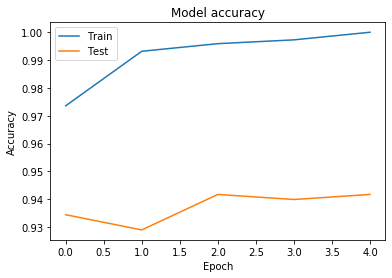

In [71]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Predictions

In [0]:
predictions = model2.predict(encodeText(x_test))
most_likely = predictions.argmax(1)

In [54]:
index = random.randrange(len(predictions))
print(x_test[index])
print('Prediction: %d, label: %d' % (most_likely[index], y_test[index]))

The only thing really worth watching was the scenery and the house, because it is beautiful.  
Prediction: 1, label: 1


# Error Analysis

It was horrendous.  
Prediction: 1, label: 0


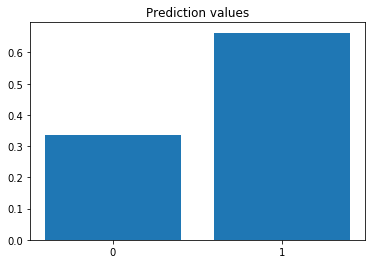

In [65]:
for i in range(1000):
    index = random.randrange(len(predictions))
    if most_likely[index] != y_test[index]:
        break

print(x_test[index])
print('Prediction: %d, label: %d' % (most_likely[index], y_test[index]))

plt.bar(range(2), predictions[index], tick_label=range(2))
plt.title('Prediction values')
plt.show()